In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.io import loadmat
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (10.0, 10.0)
%config InlineBackend.figure_format = 'retina'

In [2]:
from lab8_common import *

In [3]:
def draw(particles, true_values, predicted_values, t):
    clear_output(wait=True)
    show_map( room_map )
    plt.scatter(particles[0,:] , particles[1,:], s=3)
    plt.plot(true_values[0,:t],  true_values[1,:t] , c= "green", label="Actual Position")
    plt.plot(predicted_values[0,:t], predicted_values[1,:t], c= "red", label="Estimated Position")
    plt.legend(loc=1)
    plt.title("Room map")
    plt.show()

In [44]:
def init_particles(n):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    th = np.random.uniform(0, 2 * 3.14159, n)
    return np.stack((x, y, th))

def get_noise():
    x = np.random.normal(0, sigma_proposal, n)
    y = np.random.normal(0, sigma_proposal, n)
    th = np.random.uniform(0, sigma_proposal, n)
    return np.stack((x, y, th))

def get_particles(parts=None, weights=None):
    if parts is None:
        parts = init_particles(n)
    if weights is None:
        weights = np.ones(n)
    weights = weights.flatten() / np.sum(weights)
    inds = np.random.choice(n, p=weights, size=n, replace=True)
    parts = parts[:,inds]
    parts[:2,:] += get_noise()[:2,:]
#     parts[2,:] = get_noise()[2,:]
    return parts

#gaussian likelihood
def get_like_guas(y, parts):
    likes = np.exp(-sigma_like * np.sum(np.square(y - cast_rays(parts, room_map)), axis=1, keepdims=True))
    return likes / np.sum(likes)

#laplacian likelihood
def get_like_lap(y, parts):
    likes = np.exp(-sigma_like * np.sum(abs(y - cast_rays(parts, room_map)), axis=1, keepdims=True))
    return likes / np.sum(likes)

def get_expected_val(parts, likes):
    return np.sum(parts.T * likes, axis=0)

In [6]:
room_map = create_map()
data = loadmat('sensors.mat')
sonars = data['sonars']
true_states = data['true_states']

In [74]:
S = sonars.shape[-1]
n = 1000
sigma_proposal = .01
sigma_like = 10

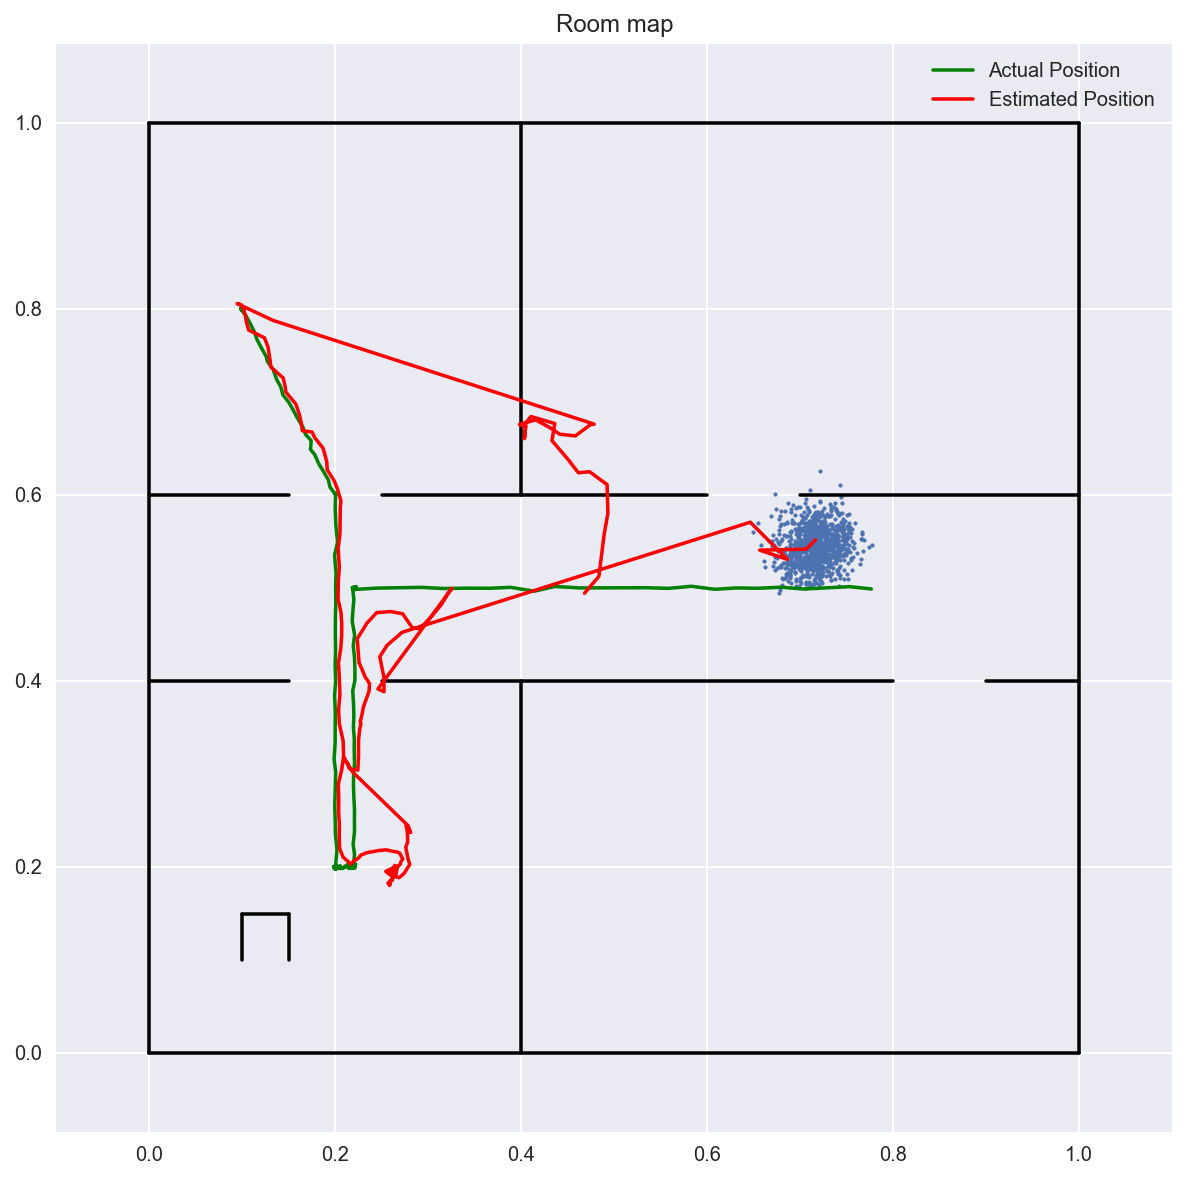

In [142]:
parts = get_particles()
preds = []
for i in range(S):
    likes = get_like_lap(sonars[:,i], parts)
    preds.append(get_expected_val(parts, likes))
    if i % 32 == 0:
        draw(parts, true_states, np.atleast_2d(preds).T, i)
    if i % 1 == 0:
        parts = get_particles(parts, likes)